# Project Delivery Part 2 

In this second delivery, we move from the rule-based scoring system developed in Week 1 to a machine-learning approach. The goal remains the same: identify which clients to contact for investment products. However, instead of manually defined business rules, we now train classification models (Decision Tree and Logistic Regression) on historical data and use their predicted probabilities to rank clients.

Additionally, we now have feedback from Period 1 — the results of the 1,200 clients we chose to contact in the first submission. This allows us to enlarge our training data with real outcomes and refine our predictions for Period 2.

## 1. Setup and Imports
We import all necessary libraries upfront. The workflow is organised into four blocks: data handling (numpy, pandas), preprocessing (sklearn.pipeline, sklearn.impute, sklearn.preprocessing), modeling and tuning (DecisionTreeClassifier, LogisticRegression, GridSearchCV), and evaluation/visualisation (roc_auc_score, matplotlib, seaborn).


In [55]:
# Core
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, RocCurveDisplay, accuracy_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


## 2. Data Loading

- **period_0.csv** — Historical data with 7,700 clients including known investment outcomes. This is our primary training data.
- **period_1_prediction.csv** — The 7,700 clients from Period 1 (features only, no outcomes).
- **period_2_prediction.csv** — The 7,700 clients from Period 2 for which we must make predictions.
- **results-2026-02-26.csv** — Actual investment results for the 1,200 clients selected in Submission 1. This feedback allows us to enlarge our training set.

In [56]:
df_0 = pd.read_csv("period_0.csv")
df_1 = pd.read_csv("period_1_prediction.csv")
df_2 = pd.read_csv("period_2_prediction.csv")
df_1_result=pd.read_csv("results-2026-02-26.csv")

print(f"Period 0: {df_0.shape}")
print(f"Period 1: {df_1.shape}")
print(f"Period 2: {df_2.shape}")
print(f"Period 1 result {df_1_result.shape}")

Period 0: (7700, 14)
Period 1: (7700, 12)
Period 2: (7700, 12)
Period 1 result (1200, 4)


## 3. Data Inspection

In [57]:
print("=== period_0.csv (df_0) ===")
display(df_0.head())

print("=== period_1_prediction.csv (df_1) ===")
display(df_1.head())

print("=== period_2_prediction.csv (df_2) ===")
display(df_2.head())

print("=== results-2026-02-26.csv (df_1_result) ===")
display(df_1_result.head())

=== period_0.csv (df_0) ===


,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,entrepreneur,single,tertiary,cellular,38,no,no,0,unknown,185,0.00,0
1,2,29,management,married,tertiary,cellular,1022,yes,no,0,unknown,408,0.00,0
2,3,49,blue-collar,divorced,secondary,cellular,10613,no,yes,0,unknown,1226,1264.69,0
3,4,23,management,single,tertiary,cellular,736,yes,no,0,unknown,119,0.00,0
4,5,42,technician,married,secondary,NaN,-158,yes,no,0,unknown,124,0.00,0


=== period_1_prediction.csv (df_1) ===


,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period
0,7701,42,housemaid,married,primary,cellular,4387.28,yes,no,1,low,1
1,7702,28,technician,single,secondary,NaN,2082.94,yes,no,0,unknown,1
2,7703,58,admin.,married,secondary,cellular,4022.23,no,no,2,low,1
3,7704,26,technician,divorced,tertiary,NaN,3186.70,yes,yes,1,unknown,1
4,7705,32,admin.,married,secondary,cellular,1550.86,no,yes,0,unknown,1


=== period_2_prediction.csv (df_2) ===


,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,period
0,15401,40,services,married,secondary,cellular,3192.19,yes,no,0,unknown,2
1,15402,44,technician,married,secondary,cellular,5266.33,no,no,0,unknown,2
2,15403,33,NaN,married,secondary,cellular,362.91,no,no,6,low,2
3,15404,36,unemployed,divorced,primary,telephone,-20.18,no,no,1,unknown,2
4,15405,58,retired,married,primary,cellular,-89.65,yes,yes,0,unknown,2


=== results-2026-02-26.csv (df_1_result) ===


,id,investment,week_id,timestamp
0,7712,0.00,1,20260213121907
1,7721,529.92,1,20260213121907
2,7725,0.00,1,20260213121907
3,7726,436.40,1,20260213121907
4,7732,0.00,1,20260213121907


## 4. Data Preparation
In order to work with our data we have to prepare the tables depending how we approach the task


### 4.1 Strategy

Since we now have observed outcomes for the clients contacted in Period 1, we refine our strategy by expanding the original Period 0 training dataset with these newly labeled cases. Specifically, we match the contacted clients to their Period 1 feature records, attach their realized investment results, and append them to the historical data. The reason for this is straightforward: a larger training set with more labeled examples allows the model to learn more robust patterns.

In [58]:
df_period0_raw = pd.read_csv("period_0.csv")

# Step 1: Use all IDs from the Period 1 results file
result_ids = df_1_result['id'].drop_duplicates()
print(f"IDs in results file: {len(result_ids)}")

# Step 2: Retrieve those clients' features from period_1_prediction
df_period1_selected = df_1[df_1['id'].isin(result_ids)].copy()
print(f"Matched in period_1_prediction.csv: {len(df_period1_selected)}")

# Step 3: Attach observed investment outcome
df_period1_selected = df_period1_selected.merge(
    df_1_result[['id', 'investment']], on='id', how='left'
 )

# Step 4: Create binary investment label
df_period1_selected['invested'] = (df_period1_selected['investment'] > 0).astype(int)

print(f"\nPeriod 1 — actual investors:  {df_period1_selected['invested'].sum()}")
print(f"Period 1 — did not invest:    {(df_period1_selected['invested'] == 0).sum()}")
print(f"Period 1 — investment NaN:    {df_period1_selected['investment'].isna().sum()}")

# Step 5: Enlarge training data by appending new labeled Period 1 rows
Enlarged_dataset = pd.concat([df_period0_raw, df_period1_selected], ignore_index=True)

# Step 6: Diagnostic flag: contacted in Period 1 and actually invested
Enlarged_dataset['correctly_predicted'] = (
    (Enlarged_dataset['period'] == 1) & (Enlarged_dataset['invested'] > 0)
).astype(int)

print(f"\nPeriod 0 rows:          {len(df_period0_raw)}")
print(f"Period 1 rows added:    {len(df_period1_selected)}")
print(f"Enlarged dataset total: {len(Enlarged_dataset)}")
print(f"Correctly predicted:    {Enlarged_dataset['correctly_predicted'].sum()}")

IDs in results file: 1200
Matched in period_1_prediction.csv: 1200

Period 1 — actual investors:  251
Period 1 — did not invest:    949
Period 1 — investment NaN:    0

Period 0 rows:          7700
Period 1 rows added:    1200
Enlarged dataset total: 8900
Correctly predicted:    251


In [59]:
print(Enlarged_dataset)

         id  age           job   marital  education preferred_contact  \
0         1   31  entrepreneur    single   tertiary          cellular   
1         2   29    management   married   tertiary          cellular   
2         3   49   blue-collar  divorced  secondary          cellular   
3         4   23    management    single   tertiary          cellular   
4         5   42    technician   married  secondary               NaN   
...     ...  ...           ...       ...        ...               ...   
8895  15372   50    unemployed    single  secondary         telephone   
8896  15376   36    technician    single  secondary          cellular   
8897  15384   41    management   married   tertiary               NaN   
8898  15396   34      services   married  secondary          cellular   
8899  15400   53    management   married   tertiary          cellular   

       balance loan_house loan_personal  n_marketing_contacts  \
0        38.00         no            no                   

### 4.2 Creating the Target Variable

In [60]:
Enlarged_dataset["profit"] = (Enlarged_dataset["investment"].values * 0.045) - 5
Enlarged_dataset["profit_status"] = (Enlarged_dataset["profit"] > 0).astype(int)
print(f"profit_rate: {Enlarged_dataset['profit_status'].mean():.3f}")
print(f"\nDistribution:")
print(Enlarged_dataset['profit_status'].value_counts())

profit_rate: 0.116

Distribution:
profit_status
0    7872
1    1028
Name: count, dtype: int64


A client is labelled profit_status = 1 if this profit is positive.  Only ~11.6% of clients in the enlarged dataset are profitable. This class imbalance means the model will see far more non-profitable cases during training and may default to always predicting "not profitable." We address this during modeling through *stratified splitting* in later stages

### 4.3 Defining Features and Target

In [61]:
Enlarged_dataset.columns


Index(['id', 'age', 'job', 'marital', 'education', 'preferred_contact',
       'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts',
       'marketing_potential', 'call_length', 'investment', 'period',
       'invested', 'correctly_predicted', 'profit', 'profit_status'],
      dtype='str')

In order to see what columns we will need to drop, we have to look at the current columns. From this we can see that profit_status, investment, id, period, call_length and profit can be dropped.

In [62]:
# Columns to remove
drop_cols = ['profit_status', 'investment', 'id', 'period', 'call_length', 'profit', 'invested', 'correctly_predicted']

X = Enlarged_dataset.drop(columns=[c for c in drop_cols if c in Enlarged_dataset.columns])
y = Enlarged_dataset['profit_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Features shape: (8900, 10)
Target shape: (8900,)

Feature columns:
['age', 'job', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential']


- **`profit_status`**: Target variable (**y**). Including it as a feature would cause target leakage.
- **`profit`**: Directly computed from `investment`; used only to derive the target.
- **`investment`**: Outcome variable itself; using it would mean the model already knows the result.
- **`id`**: Unique identifier with no predictive signal.
- **`period`**: Indicates dataset origin (Period 0 or 1), not a client attribute.
- **`call_length`**: Available only in Period 0 and known only after contact, so unavailable at decision time.
- **`invested`** and **`correctly_predicted`**: Outcome-derived variables, unavailable for future prediction periods.

## 5. Train-Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass balance train: {y_train.mean():.3f}")
print(f"Class balance test:  {y_test.mean():.3f}")

Training set: (7120, 10)
Test set: (1780, 10)

Class balance train: 0.115
Class balance test:  0.116


We split the enlarged dataset into 80% training and 20% test data. The stratify=y parameter ensures that both sets maintain the same proportion of profitable vs. non-profitable clients (~11.6%). Without stratification, random chance could create an uneven split, leading to unreliable evaluation results.

## 6. Preprocessing Pipeline

Machine learning models require clean, numerical input. Our dataset contains both categorical text variables (e.g., `job`, `education`) and occasional missing values. The preprocessing pipeline handles both in a structured, reproducible way:

- **Categorical variables**: Missing values are replaced with `"missing"` (a new category), then one-hot encoded into binary columns. Rare categories (appearing in fewer than 5% of rows) are grouped into an `"infrequent"` bucket to avoid excessive dimensionality.
- **Numerical variables**: Missing values are filled with the column median.
- **Scaling**: No feature scaling is applied here because Decision Trees are invariant to feature scale. For Logistic Regression, scaling is added in a separate pipeline later.

In [64]:
# Categorical: fill missing → one-hot encode
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        drop=None 
    ))
])

# Numeric: fill missing with median
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)


The preprocessing pipeline handles categorical and numeric variables separately. Categorical variables have missing values replaced with "missing" and are then one-hot encoded into binary columns. Rare categories (below 5%) are grouped into an "infrequent" class. Numeric variables have missing values filled with the median however this is not the case for our dataset since all numeric variables are given. No scaling is applied as Decision Trees are not affected by different feature scales. The pipeline ensures consistent preprocessing during both training and prediction.

## 7. Baseline Decision Tree

Before tuning any hyperparameters, we train a baseline Decision Tree with default settings. This serves as a reference point: if our tuned model cannot beat the baseline, the tuning was not effective.

The pipeline includes a VarianceThreshold filter that removes features with near-zero variance (threshold = 0.01), as these carry almost no information.

In [65]:
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit baseline model with default parameters
pipeline_dt.fit(X_train, y_train)

train_acc = pipeline_dt.score(X_train, y_train)
test_acc = pipeline_dt.score(X_test, y_test)

print(f"=== Baseline Decision Tree ===")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")




=== Baseline Decision Tree ===
Training accuracy: 0.999
Test accuracy:     0.824


### 7.1 Naive Baseline Comparison
To properly contextualize model performance, we compare against the naïve baseline: always predicting "not profitable" for every client. Given the class imbalance (~88% non-profitable), this trivial strategy already achieves ~88% accuracy without any model at all.

In [66]:

# Naive baseline: always predict "no investment"
non_investors = (y_test == 0).sum()
total = len(y_test)
naive_accuracy = non_investors / total

print(f"=== Naive Baseline (Always Predict No Investment) ===")
print(f"Non-investors in test set: {non_investors} / {total}")
print(f"Naive accuracy:            {naive_accuracy:.3f}")
print(f"→ A model predicting 'no investment' for everyone achieves {naive_accuracy*100:.1f}% accuracy")

=== Naive Baseline (Always Predict No Investment) ===
Non-investors in test set: 1574 / 1780
Naive accuracy:            0.884
→ A model predicting 'no investment' for everyone achieves 88.4% accuracy


## 8. Hyperparameter Tuning with GridSearchCV

We use GridSearchCV with 5-fold cross-validation to systematically search for the best combination of hyperparameters. The scoring metric is ROC-AUC, which measures how well the model ranks profitable clients above non-profitable ones — exactly what we need for our selection task.

Key parameters being tuned:

- max_depth: Limits tree depth to prevent overfitting.
- min_samples_split / min_samples_leaf: Requires minimum observations before splitting, preventing the tree from memorising individual data points.
- class_weight: When set to 'balanced', the model upweights the minority class (profitable clients) during training.
- var_filter__threshold: Controls which low-variance features are removed.

In [67]:
parameters = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__max_depth': [3, 6, 7, 8, None],
    'classifier__min_samples_split': [7 ,10],
    'classifier__min_samples_leaf': [ 46, 48,50],
    'classifier__class_weight': ['balanced', None]
}

cv = GridSearchCV(
    pipeline_dt,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv.fit(X_train, y_train)

print(f"\nBest parameters: {cv.best_params_}")
print(f"Best CV ROC-AUC: {cv.best_score_:.3f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 7, 'var_filter__threshold': 0.05}
Best CV ROC-AUC: 0.730



We use GridSearchCV with 5-fold cross-validation to systematically search for the best combination of hyperparameters. The scoring metric is *ROC-AUC*, which measures how well the model ranks profitable clients above non-profitable ones — exactly what we need for our selection task.

Key parameters being tuned:

- *max_depth* [3, 6, 7, 8, None]: Controls tree complexity. We test a range from shallow to unlimited to find the sweet spot between underfitting and overfitting.
- *min_samples_split* [7, 10] / *min_samples_leaf* [46, 48, 50]: Prevent the tree from memorising noise by requiring a minimum number of observations per split and leaf. Values around 50 ensure each leaf covers a meaningful portion of the data.
- *class_weight* ['balanced', None]: Tests whether upweighting the minority class (profitable clients) improves detection or if the model performs better without adjustment.
- *var_filter__threshold* [0.01, 0.05]: Controls how aggressively low-variance features are removed before training.

GridSearchCV tested all 120 combinations across 5 folds (600 fits). The best model achieved a cross-validated ROC-AUC of *0.730* with max_depth=7, min_samples_leaf=50, min_samples_split=7, class_weight=None, and var_filter__threshold=0.05.

## 9. Decision Tree Evaluation

In [68]:
y_pred = cv.predict(X_test)
y_prob = cv.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"=== Optimized Decision Tree ===")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test ROC-AUC:  {test_auc:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Profit', 'profit']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Decision Tree ===
Test Accuracy: 0.894
Test ROC-AUC:  0.703

Classification Report:
              precision    recall  f1-score   support

   No Profit       0.90      0.99      0.94      1574
      profit       0.67      0.16      0.26       206

    accuracy                           0.89      1780
   macro avg       0.79      0.58      0.60      1780
weighted avg       0.87      0.89      0.86      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33


We evaluate the tuned Decision Tree on the held-out test set using multiple metrics: accuracy, ROC-AUC, the full classification report (precision, recall, F1), and the confusion matrix.

The model achieves a test accuracy of 89.4% and a ROC-AUC of 0.703. While the accuracy looks high, it is only marginally above the naive baseline of 88.4% (always predicting "no profit"). The confusion matrix reveals why: the model correctly identifies 1,558 non-profitable clients but only detects 33 out of 206 actually profitable ones — a recall of just 16%. When it does predict profit, it is correct 67% of the time (precision), but it misses the vast majority of profitable clients. This conservative behaviour is typical for imbalanced datasets where the model defaults to the majority class. The ROC-AUC of 0.703, however, confirms that the model's underlying probability ranking is still better than random (0.5), which is what matters for our client selection — we rank clients by predicted probability rather than relying on a fixed threshold

## 9.1 Visual Representation of the Decision Tree

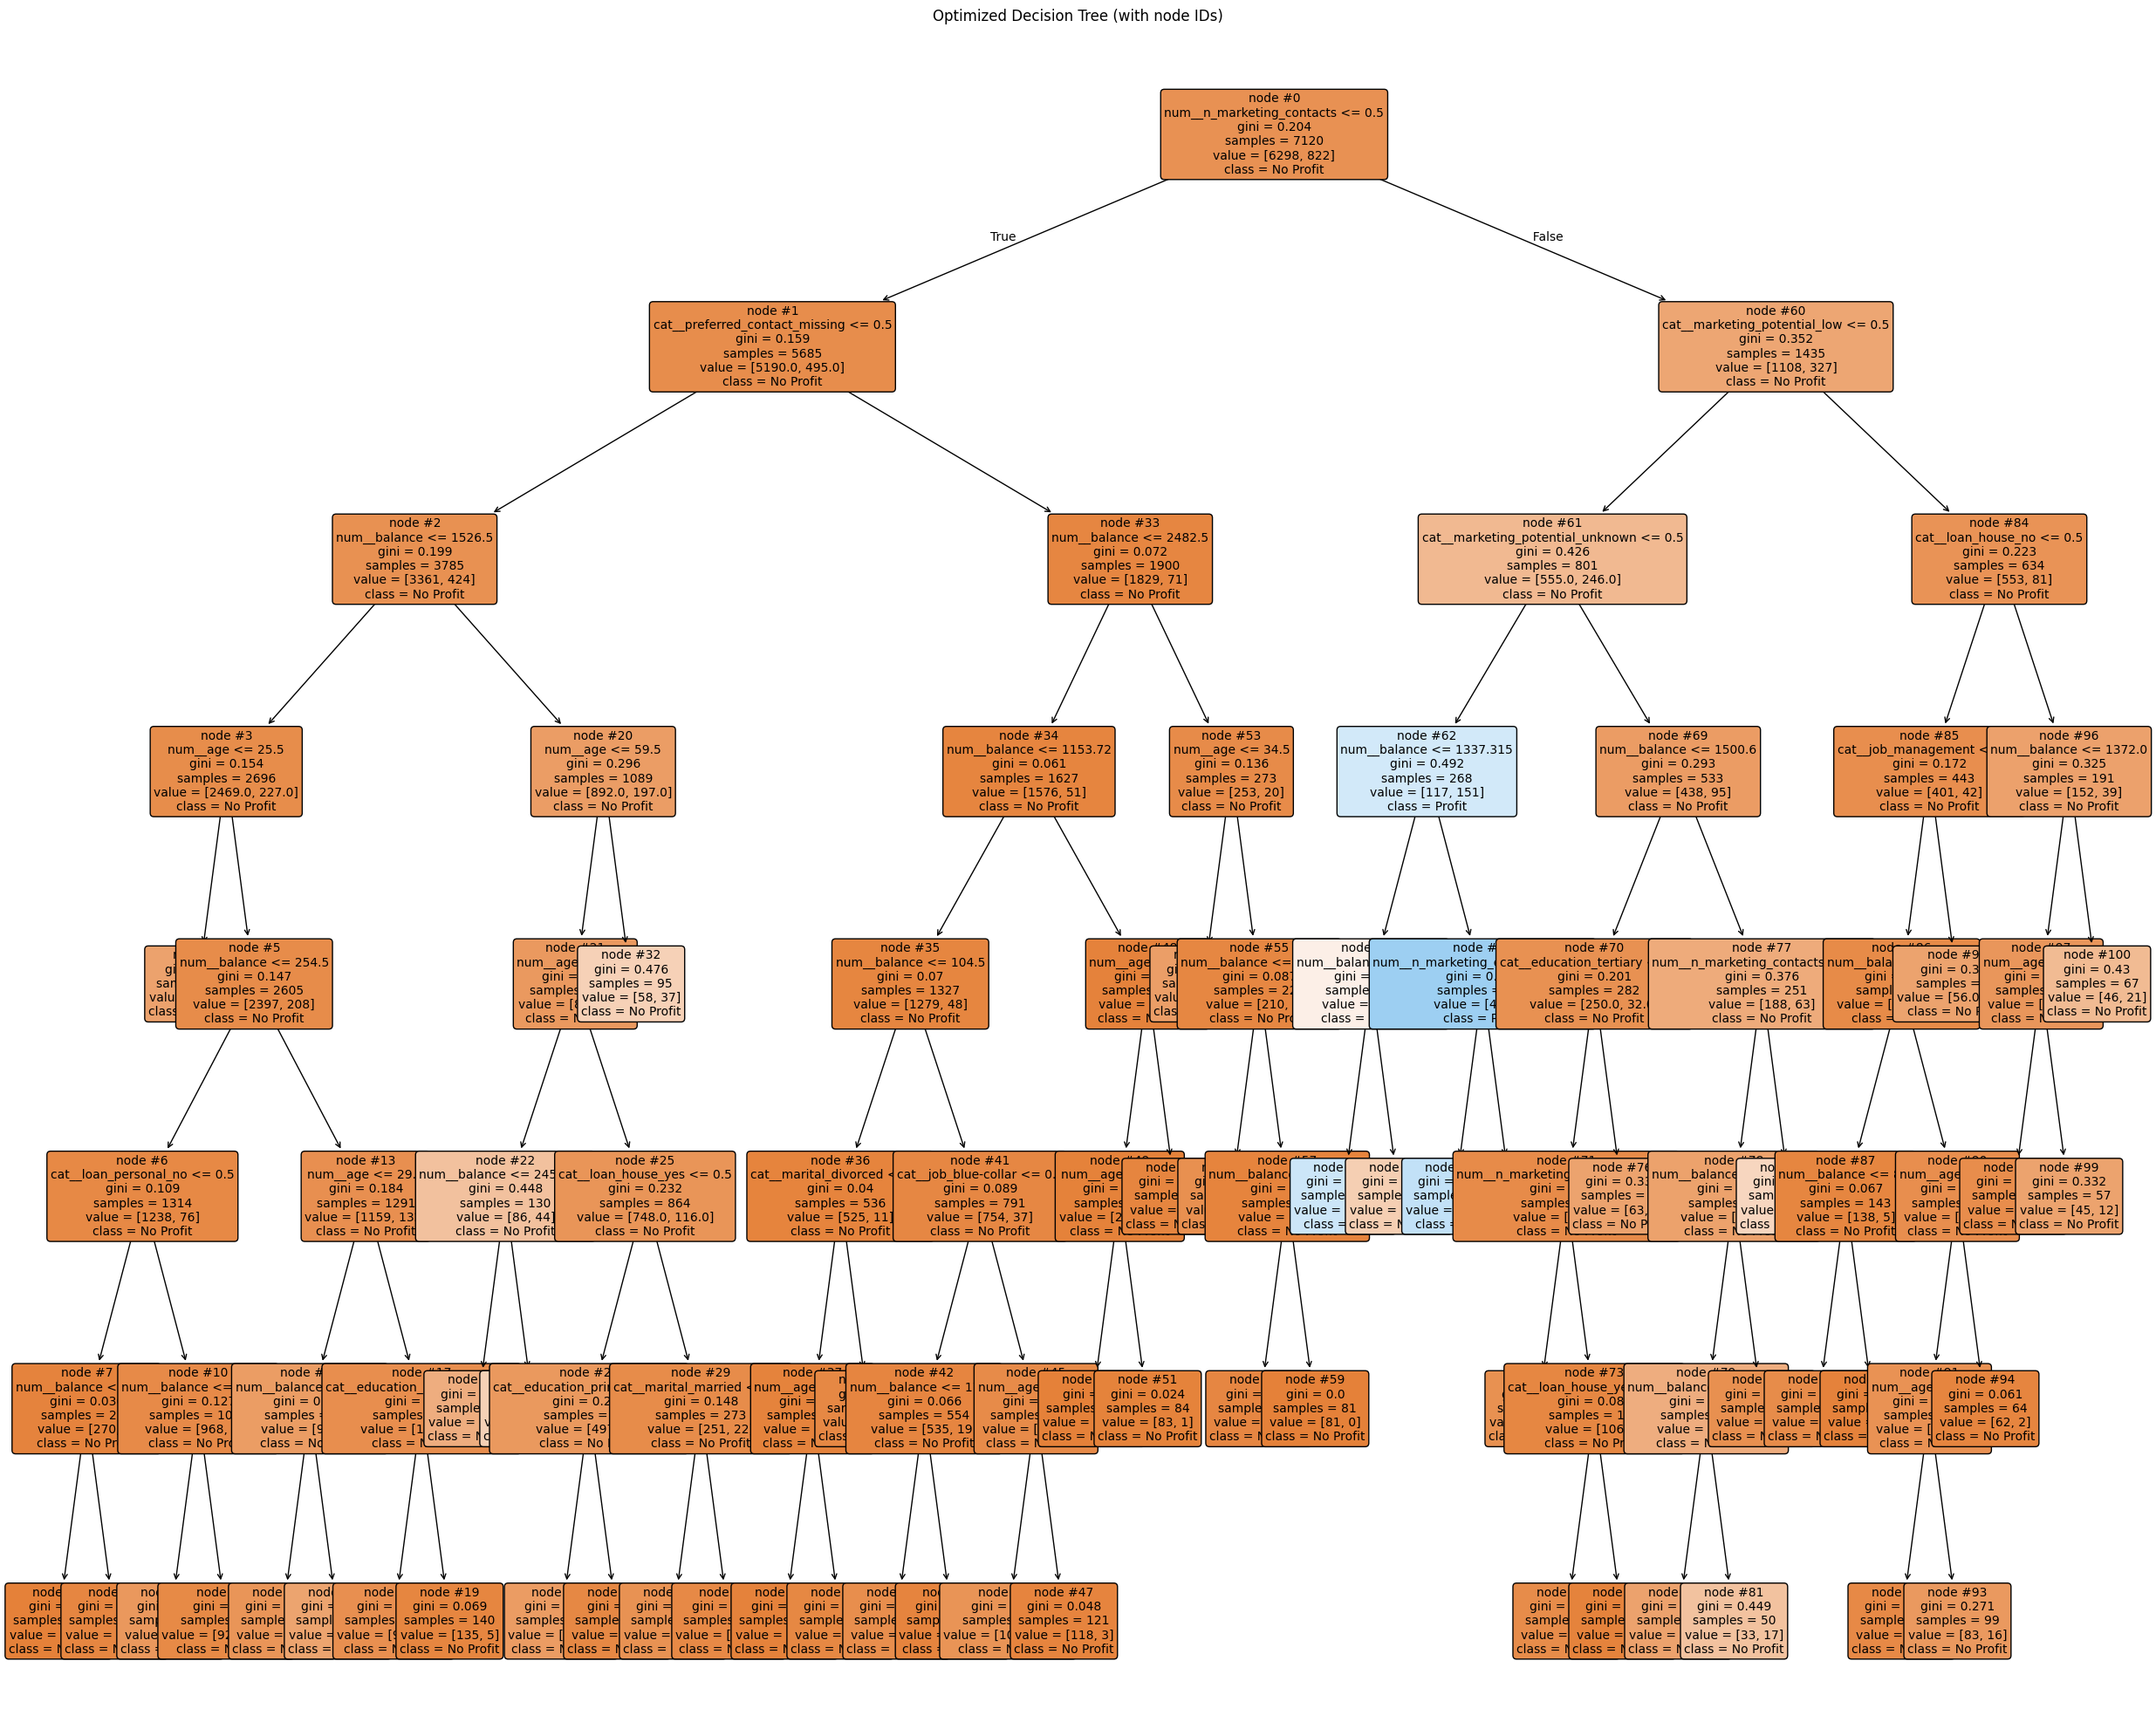

In [81]:
best_tree = cv.best_estimator_.named_steps['classifier']

feature_names_all_dt = cv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
variance_mask_dt = cv.best_estimator_.named_steps['var_filter'].get_support()
selected_features_dt = feature_names_all_dt[variance_mask_dt]

plt.figure(figsize=(25, 20))
tree.plot_tree(
    best_tree,
    feature_names=selected_features_dt,
    class_names=['No Profit', 'Profit'],
    filled=True,
    rounded=True,
    fontsize=10,
    node_ids=True
 )
plt.title('Optimized Decision Tree (with node IDs)')
plt.tight_layout()
plt.show()

In [82]:
# Terminal leaves from the plotted Decision Tree
BALANCE_COL = "balance"
AMOUNT_COL  = "investment"
INVESTS_COL = "invested"

best_pipeline = cv.best_estimator_
preprocessor = best_pipeline.named_steps["preprocess"]
var_filter = best_pipeline.named_steps["var_filter"]
model = best_pipeline.named_steps["classifier"]

# Leaf id per training row (terminal node id)
X_train_transformed = var_filter.transform(preprocessor.transform(X_train))
train_leaf_ids = model.apply(X_train_transformed)

leaf_data = pd.DataFrame({
    "leaf_id": train_leaf_ids,
    BALANCE_COL: Enlarged_dataset.loc[X_train.index, BALANCE_COL].values,
    AMOUNT_COL: Enlarged_dataset.loc[X_train.index, AMOUNT_COL].values,
    INVESTS_COL: Enlarged_dataset.loc[X_train.index, INVESTS_COL].values
})

leaf_summary = leaf_data.groupby("leaf_id", dropna=False).agg(
    n=("leaf_id", "size"),
    n_investors=(INVESTS_COL, "sum"),
    sum_amount=(AMOUNT_COL, "sum"),
    sum_balance=(BALANCE_COL, "sum")
).reset_index()

leaf_summary["propensity"] = leaf_summary["n_investors"] / leaf_summary["n"]
leaf_summary["leaf_utilization_ratio"] = leaf_summary["sum_amount"] / leaf_summary["sum_balance"].replace(0, np.nan)
leaf_summary["expected_rate"] = leaf_summary["propensity"] * leaf_summary["leaf_utilization_ratio"]

# Strict consistency check with terminal nodes of drawn tree
tree_leaf_ids = np.where(model.tree_.children_left == -1)[0]
applied_leaf_ids = np.sort(leaf_summary["leaf_id"].unique())
missing_in_apply = np.setdiff1d(tree_leaf_ids, applied_leaf_ids)
extra_in_apply = np.setdiff1d(applied_leaf_ids, tree_leaf_ids)

print("Leaf consistency check:")
print(f"Tree terminal leaves: {len(tree_leaf_ids)}")
print(f"Leaves from apply(...): {len(applied_leaf_ids)}")
print(f"Missing from apply: {len(missing_in_apply)}")
print(f"Extra in apply: {len(extra_in_apply)}")
print(f"Minimum terminal-leaf size: {leaf_summary['n'].min()}")

display(
    leaf_summary[["leaf_id", "n", "n_investors", "propensity", "leaf_utilization_ratio", "expected_rate"]]
    .sort_values("leaf_id")
    .reset_index(drop=True)
)

Leaf consistency check:
Tree terminal leaves: 51
Leaves from apply(...): 51
Missing from apply: 0
Extra in apply: 0
Minimum terminal-leaf size: 50


,leaf_id,n,n_investors,propensity,leaf_utilization_ratio,expected_rate
0,4,91,3.0,0.032967,0.176582,0.005821
1,8,153,0.0,0.000000,-0.002936,-0.000000
2,9,122,0.0,0.000000,0.052785,0.000000
3,11,52,0.0,0.000000,-0.069846,-0.000000
4,12,987,0.0,0.000000,0.390463,0.000000
5,15,52,0.0,0.000000,0.097179,0.000000
6,16,65,4.0,0.061538,0.082061,0.005050
7,18,1034,25.0,0.024178,0.051146,0.001237
8,19,140,2.0,0.014286,0.017597,0.000251
9,23,50,5.0,0.100000,0.064092,0.006409


In [ ]:
#give confusion matrix on different threshold visually appealing
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1389             185
Actual: Yes            126              80

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1574               0
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             561            1013
Actual: Yes             33             173



The default classification threshold is 0.5, but this may not be optimal for our task. Since each missed profitable client is lost revenue, we are willing to accept more false positives in exchange for catching more true profitable clients.

- *Threshold 0.8*: Predicts no one as profitable — misses all 206 profitable clients. Too conservative.
- *Threshold 0.5* (default): Detects only 33 of 206 profitable clients (recall = 16%). Very few false positives, but misses too many.
- *Threshold 0.2*: Detects 80 of 206 profitable clients (recall = 39%) with 185 false positives. A better balance.
- *Threshold 0.06*: Detects 173 of 206 profitable clients (recall = 84%) with 1,013 false positives. Captures almost all profitable clients.

A lower threshold suits our use case — rather than relying on a fixed cutoff, we rank all clients by predicted probability and select the top 1,200 for contact.

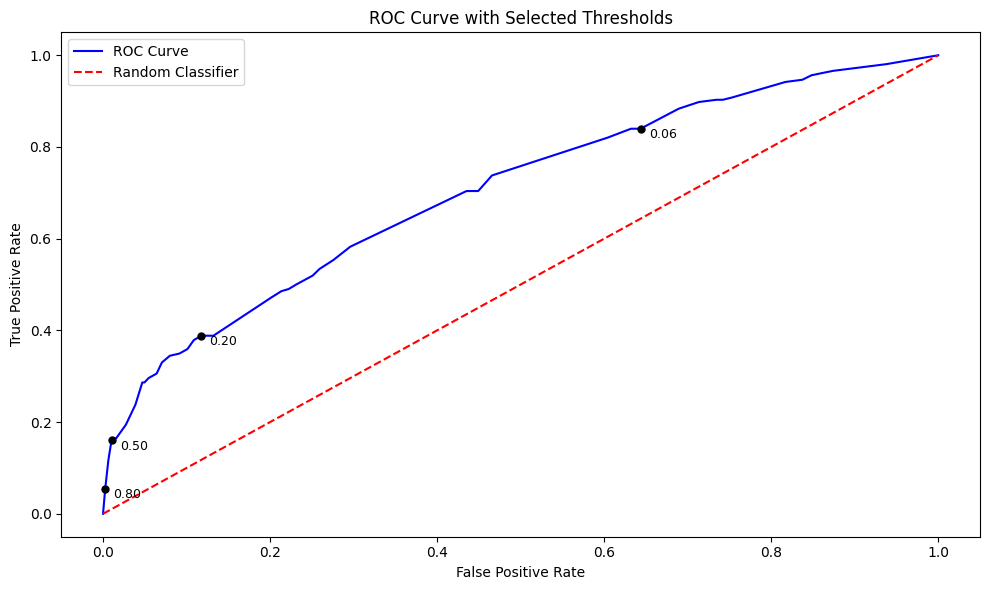

In [ ]:
# Specify the thresholds you want to annotate
thresholds_to_plot = [0.2, 0.5, 0.8, 0.06]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cv.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Selected Thresholds")
plt.legend()

# Annotate only the specified thresholds
for threshold in thresholds_to_plot:
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.plot(fpr[idx], tpr[idx], 'ko', markersize=5)
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


The ROC curve visualises the trade-off between true positive rate (recall) and false positive rate at every possible threshold. The annotated points show where our selected thresholds (0.06, 0.2, 0.5, 0.8) fall on this curve. In our business context, we are willing to move towards the upper-right corner (more contacts, more catches) rather than the lower-left (fewer contacts, more misses).

## 10 Logistic Regression

We train a second model — Logistic Regression — to compare against the Decision Tree. Unlike trees, Logistic Regression requires scaled features because it is sensitive to different value ranges. We therefore create a new preprocessing pipeline that includes StandardScaler for numeric features.

The hyperparameter C controls regularisation strength: smaller values create simpler models that are less likely to overfit. We also test different class weights to handle the imbalance.

In [ ]:

from sklearn.preprocessing import StandardScaler

# New numeric pipeline WITH scaling (needed for Logistic Regression)
numeric_pipeline_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# New preprocessor with scaling
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline_scaled, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


params_lr = {
    'var_filter__threshold': [0.0, 0.01, 0.02],
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced', {0: 1, 1: 3}],
    'classifier__max_iter': [2000]
}

cv_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

cv_lr.fit(X_train, y_train)

print(f"\nBest parameters: {cv_lr.best_params_}")
print(f"Best CV ROC-AUC: {cv_lr.best_score_:.3f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid thi


Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'var_filter__threshold': 0.0}
Best CV ROC-AUC: 0.736


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid thi

Unlike Decision Trees, Logistic Regression requires scaled features because it is sensitive to different value ranges. The parameter C controls regularization — smaller values create a simpler model that is less likely to overfit. GridSearchCV finds the best combination using 5-fold cross-validation.

### 10.1 Logistic Regression Evaluation

In [ ]:
y_pred_lr = cv_lr.predict(X_test)
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]



test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"=== Optimized Logistic Regression ===")
print(f"Test Accuracy: {test_accuracy_lr:.3f}")
print(f"Test ROC-AUC:  {test_auc_lr:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(pd.DataFrame(cm_lr,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Logistic Regression ===
Test Accuracy: 0.893
Test ROC-AUC:  0.709

Classification Report:
               precision    recall  f1-score   support

No Investment       0.90      0.99      0.94      1574
   Investment       0.63      0.18      0.28       206

     accuracy                           0.89      1780
    macro avg       0.76      0.58      0.61      1780
 weighted avg       0.87      0.89      0.87      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37


The Logistic Regression achieves a test accuracy of 89.3% and a ROC-AUC of 0.709. Similar to the Decision Tree, accuracy is close to the naive baseline (88.4%), so it alone is not a reliable metric. The model detects 37 of 206 profitable clients (recall = 18%) with a precision of 63% — slightly better recall than the Decision Tree (16%) but still missing the majority of profitable clients. 

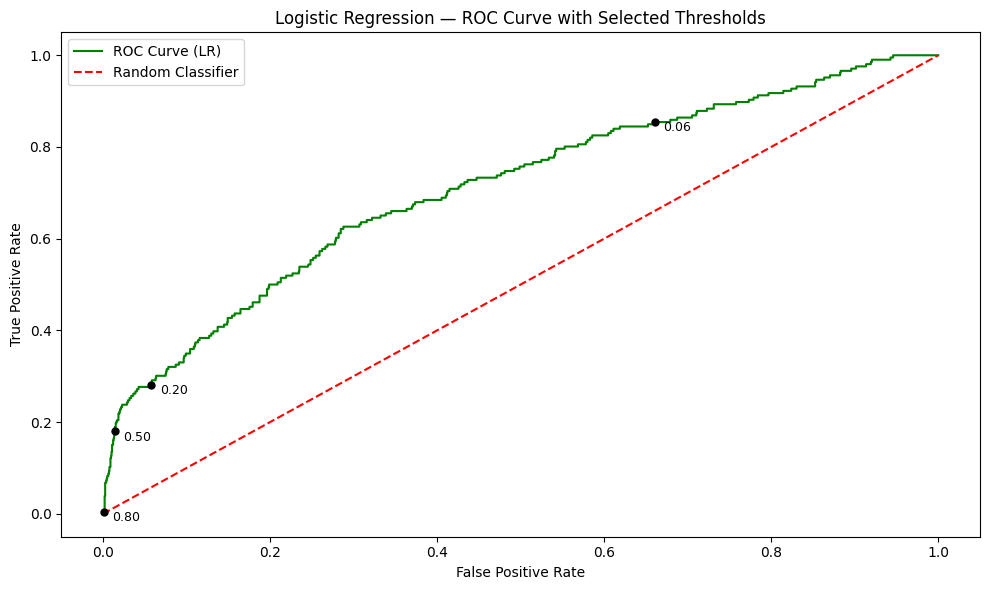

In [ ]:

# ROC Curve with threshold annotations — Logistic Regression
thresholds_to_plot_lr = [0.2, 0.5, 0.8, 0.06]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, cv_lr.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label="ROC Curve (LR)", color="green")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC Curve with Selected Thresholds")
plt.legend()

for threshold in thresholds_to_plot_lr:
    idx = (np.abs(thresholds_lr - threshold)).argmin()
    plt.plot(fpr_lr[idx], tpr_lr[idx], 'ko', markersize=5)
    plt.text(fpr_lr[idx] + 0.01, tpr_lr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


Four thresholds are annotated on the curve. At 0.80, the model is very conservative and barely detects any profitable clients. At 0.50, recall improves slightly but still remains low. At 0.20, the model catches more profitable clients with a moderate increase in false positives. At 0.06, recall is high (~84%) but comes with a large false positive rate. The curve shows the fundamental trade-off: lowering the threshold catches more profitable clients but also incorrectly flags more non-profitable ones.

In [ ]:
#create confusion matrix based on those different threshold 
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh_lr = (y_prob_lr >= thresh).astype(int)
    cm_thresh_lr = confusion_matrix(y_test, y_pred_thresh_lr)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh_lr,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1487              87
Actual: Yes            148              58

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1573               1
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             519            1055
Actual: Yes             30             176


We test the same four thresholds on the Logistic Regression to see how the trade-off between detecting profitable clients and false positives changes.

- *Threshold 0.8*: Detects 0 of 206 profitable clients and produces 1 false positive. The model is too conservative to be useful.
- *Threshold 0.5* (default): Detects 37 of 206 profitable clients (recall = 18%) with only 22 false positives. Precise but misses too many.
- *Threshold 0.2*: Detects 58 of 206 profitable clients (recall = 28%) with 87 false positives. A better balance between detection and false alarms.
- *Threshold 0.06*: Detects 176 of 206 profitable clients (recall = 85%) with 1,055 false positives. Captures nearly all profitable clients but flags many non-profitable ones.

The pattern is the same as with the Decision Tree: lower thresholds catch more profitable clients at the cost of more false positives. Since we rank clients by predicted probability and select the top 1,200, we do not rely on a fixed threshold — the ranking itself determines who gets contacted.

## 11. Model Comparison

In [ ]:
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Accuracy': [test_accuracy, test_accuracy_lr],
    'ROC-AUC': [test_auc, test_auc_lr],
    
})

print(comparison.to_string(index=False))

              Model  Accuracy  ROC-AUC
      Decision Tree  0.893820 0.703069
Logistic Regression  0.892697 0.708625



Both models were compared on ROC-AUC and accuracy. Accuracy is nearly identical (89.4% vs 89.3%) and close to the naive baseline of 88.4%, making it an unreliable metric for this imbalanced dataset. The decisive metric is *ROC-AUC, which measures how well the model ranks profitable clients above non-profitable ones — this is exactly what we need, since we rank all Period 2 clients by predicted probability and select the top 1,200. The Decision Tree achieves a ROC-AUC of 0.703, while the Logistic Regression reaches 0.709. This means the Logistic Regression is slightly better at placing truly profitable clients at the top of the ranking. Additionally, Logistic Regression produces smooth, well-calibrated probabilities, whereas the Decision Tree outputs discrete probability values tied to leaf nodes — making the ranking more granular and reliable. For these reasons, **Logistic Regression is selected as the final model* for the Period 2 prediction.


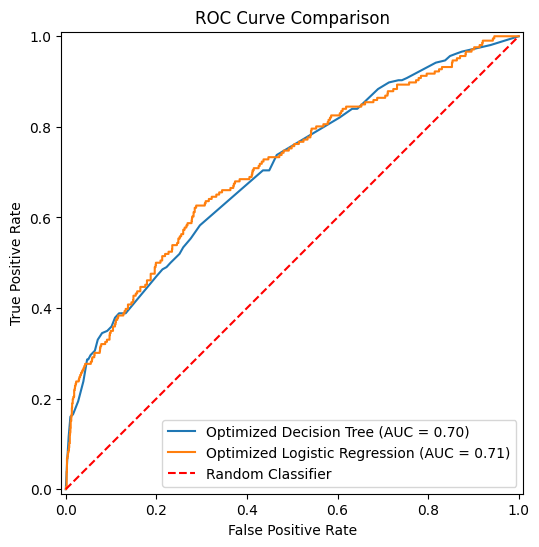

In [ ]:
# plot ROC AUC for both models
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name="Optimized Decision Tree", ax=plt.gca())
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name="Optimized Logistic Regression", ax=plt.gca())
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

The plot compares both models against the random classifier (red dashed line). Both curves sit well above the diagonal, confirming that both models are meaningfully better than random guessing. The Decision Tree (blue, AUC = 0.70) and Logistic Regression (orange, AUC = 0.71) follow very similar paths, with the Logistic Regression slightly ahead in the mid-range of false positive rates. Both models perform comparably, but the Logistic Regression holds a small but consistent advantage in ranking profitable clients — which is why we selected it as our final model.

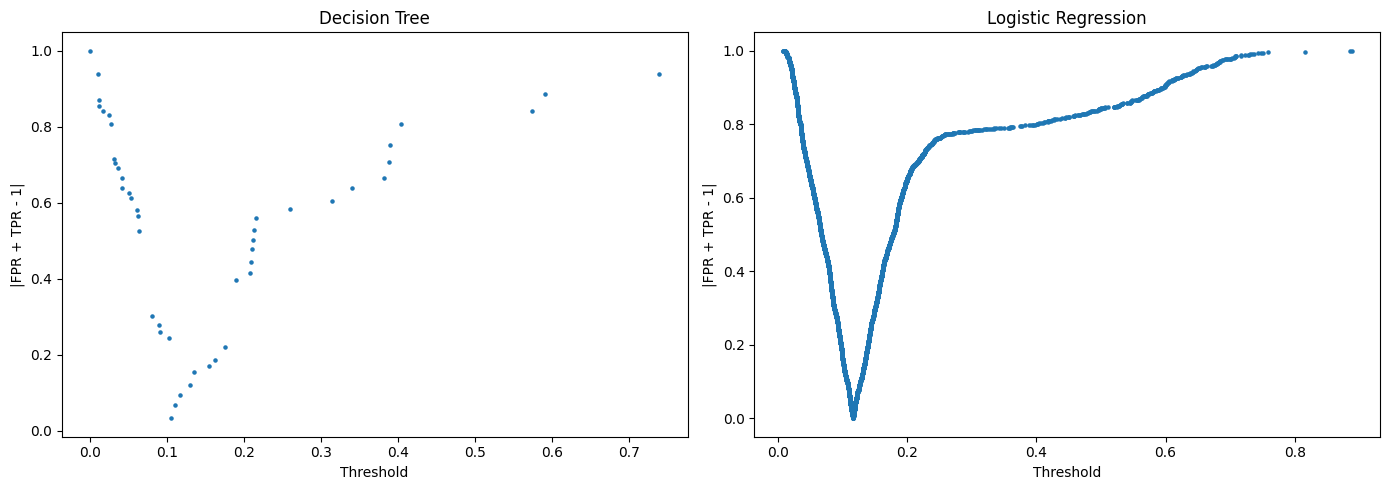

Decision Tree — optimal threshold: inf
Logistic Regression — optimal threshold: inf


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_train, cv.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_dt = np.abs(fpr_dt + tpr_dt - 1)
best_idx_dt = np.argmax(youden_dt)

axes[0].scatter(thresh_dt, youden_dt, s=5)
axes[0].axvline(thresh_dt[best_idx_dt], color='r', linestyle='--')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel("|FPR + TPR - 1|")
axes[0].set_title('Decision Tree')

# Logistic Regression
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_train, cv_lr.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_lr = np.abs(fpr_lr + tpr_lr - 1)
best_idx_lr = np.argmax(youden_lr)

axes[1].scatter(thresh_lr, youden_lr, s=5)
axes[1].axvline(thresh_lr[best_idx_lr], color='r', linestyle='--')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel("|FPR + TPR - 1|")
axes[1].set_title('Logistic Regression')

plt.tight_layout()
plt.show()

print(f"Decision Tree — optimal threshold: {thresh_dt[best_idx_dt]:.3f}")
print(f"Logistic Regression — optimal threshold: {thresh_lr[best_idx_lr]:.3f}")

## 12. Period 2 Prediction — Scoring and Ranking Clients

We now apply the trained Logistic Regression model to the Period 2 dataset to predict each client's probability of being profitable. Clients are ranked by this probability in descending order. Clients with a predicted probability higher than 0.5 are choosen since they are expected to generate profit

In [ ]:
# Table: predicted probability per person in the period_2_prediction.csv test set
# Score + rank Period 2 using predicted probabilities
df_2_ranked = pd.read_csv("period_2_prediction.csv").copy()

# Ensure same feature columns as training
X_period2 = df_2_ranked.reindex(columns=X_train.columns, fill_value=np.nan)

# Predict probability of class 1 (invest/profit)
df_2_ranked["proba_invest"] = cv_lr.predict_proba(X_period2)[:, 1]

# Rank descending (highest probability first)
df_2_ranked = df_2_ranked.sort_values("proba_invest", ascending=False).reset_index(drop=True)
df_2_ranked["rank"] = df_2_ranked.index + 1

# Set target based on probability threshold
df_2_ranked["target"] = (df_2_ranked["proba_invest"] > 0.5).astype(int)

# Save full ranking + submission
df_2_ranked.to_csv("period_2_ranked.csv", index=False)
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)

print(df_2_ranked[["id", "proba_invest", "rank", "target"]].head(15))
print("Saved: period_2_ranked.csv and submission_period_2.csv")

# find how many higher probability than 0.5
num_high_proba = (df_2_ranked["proba_invest"] > 0.5).sum()
print(f"Number of clients with predicted probability > 0.5: {num_high_proba}")


       id  proba_invest  rank  target
0   21971      0.839745     1       1
1   15845      0.786565     2       1
2   20250      0.774263     3       1
3   17278      0.767746     4       1
4   17728      0.762973     5       1
5   21050      0.754926     6       1
6   19272      0.743891     7       1
7   22954      0.741383     8       1
8   20148      0.732006     9       1
9   22470      0.717240    10       1
10  20769      0.714859    11       1
11  22692      0.703193    12       1
12  19030      0.697810    13       1
13  19664      0.695351    14       1
14  15682      0.691801    15       1
Saved: period_2_ranked.csv and submission_period_2.csv
Number of clients with predicted probability > 0.5: 169


169 have a high probability so those we will definitely however since we have space left we establish a group based ranking

We apply the trained Logistic Regression model to the Period 2 dataset to predict each client's probability of being profitable. First, we reload the Period 2 data and align its columns with the training set using reindex to ensure the model receives the same features it was trained on — any missing columns are filled with NaN and handled by the preprocessing pipeline.

Each client then receives a predicted probability (proba_invest) via predict_proba, representing how likely the model considers them to be profitable. Clients are sorted by this probability in descending order and assigned a rank (rank 1 = most likely profitable).

For the target variable, we use a threshold of 0.5: clients with a predicted probability above 0.5 are labelled target = 1 (contact), the rest target = 0. We chose 0.5 as it marks the point where the model considers a client more likely profitable than not.

## 12.1 Segment Analysis Identifying Profitable CLient Profils

In [92]:
import itertools

BALANCE_COL = "balance"
AMOUNT_COL  = "investment"
INVESTS_COL = "invested"
ID_COL      = "id"
MIN_INVESTORS = 100

# Use enlarged historical data for robust segment statistics
df_seg = Enlarged_dataset.copy()
if INVESTS_COL not in df_seg.columns:
    df_seg[INVESTS_COL] = (df_seg[AMOUNT_COL] > 0).astype(int)

def combo_summary(df_all, cols, min_count):
    g_all = df_all.groupby(cols, dropna=False)
    g_inv = df_all[df_all[INVESTS_COL] == 1].groupby(cols, dropna=False)

    n           = g_all.size().rename("n")
    n_investors = g_inv.size().rename("n_investors")
    sum_amount  = g_inv[AMOUNT_COL].sum().rename("sum_amount")
    sum_balance = g_inv[BALANCE_COL].sum().rename("sum_balance")

    out = pd.DataFrame({
        "n": n, "n_investors": n_investors,
        "sum_amount": sum_amount, "sum_balance": sum_balance,
    }).reset_index()

    out["n_investors"] = out["n_investors"].fillna(0).astype(int)
    out["sum_amount"]  = out["sum_amount"].fillna(0.0)
    out["sum_balance"] = out["sum_balance"].fillna(0.0)
    out["propensity"]  = out["n_investors"] / out["n"]
    out["utilization_ratio"] = np.where(
        out["n_investors"] >= MIN_INVESTORS,
        out["sum_amount"] / out["sum_balance"].replace(0, np.nan),
        np.nan
    )
    out["expected_rate"] = out["propensity"] * out["utilization_ratio"]
    out["stable"] = out["n_investors"] >= MIN_INVESTORS
    out = out[out["n"] >= min_count]
    return out.sort_values(["expected_rate", "utilization_ratio", "n"], ascending=False)

cat_cols = df_seg.select_dtypes(include=["object", "category", "string"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != ID_COL]
k = len(cat_cols)

per_combo_top = 3
min_count_floor = 10
min_count_scale = 80

def min_count_for_size(size):
    return max(min_count_floor, int(min_count_scale / size))

def format_segment(row, cols):
    return " | ".join(f"{c}={row[c] if pd.notna(row[c]) else '(missing)'}" for c in cols)

rows = []
for size in range(2, k + 1):
    min_count = min_count_for_size(size)
    for cols in itertools.combinations(cat_cols, size):
        cols = list(cols)
        out = combo_summary(df_seg, cols, min_count=min_count)
        if out.empty:
            continue
        best = out[out["stable"]].head(per_combo_top).copy()
        if best.empty:
            continue
        best.insert(0, "combo", " + ".join(cols))
        best.insert(1, "combo_size", size)
        best["segment"] = best.apply(lambda r: format_segment(r, cols), axis=1)
        rows.append(best[["combo", "combo_size", "segment", "n", "n_investors",
                          "propensity", "utilization_ratio", "expected_rate"]])

all_best = pd.concat(rows, ignore_index=True).sort_values(
    ["combo_size", "expected_rate", "utilization_ratio", "n"],
    ascending=[False, False, False, False]
).reset_index(drop=True)

# Build mapping-engine rule table in section 12.1 (specificity hierarchy)
def parse_segment_rule(segment_text):
    rule = {}
    parts = [p.strip() for p in str(segment_text).split("|")]
    for p in parts:
        if "=" not in p:
            continue
        key, value = p.split("=", 1)
        rule[key.strip()] = value.strip()
    return rule

application_rules = all_best[["segment", "combo_size", "utilization_ratio", "expected_rate", "n"]].copy()
application_rules["rule_dict"] = application_rules["segment"].apply(parse_segment_rule)
application_rules["specificity"] = application_rules["rule_dict"].apply(len)
application_rules = application_rules.sort_values(
    ["specificity", "combo_size", "expected_rate", "utilization_ratio", "n"],
    ascending=[False, False, False, False, False]
).reset_index(drop=True)

print(f"Best Segments: {len(all_best)}")
print(f"Rules for mapping engine: {len(application_rules)}")
display(all_best.head(20))
display(application_rules.head(20))

Best Segments: 25
Rules for mapping engine: 25


,combo,combo_size,segment,n,n_investors,propensity,utilization_ratio,expected_rate
0,marital + preferred_contact + loan_house + loa...,4,marital=married | preferred_contact=cellular |...,1750,119,0.068000,0.206567,0.014047
1,preferred_contact + loan_house + loan_personal...,4,preferred_contact=cellular | loan_house=no | l...,2604,159,0.061060,0.206512,0.012610
2,marital + loan_house + loan_personal + marketi...,4,marital=married | loan_house=no | loan_persona...,2201,105,0.047706,0.171260,0.008170
3,education + loan_house + loan_personal,3,education=tertiary | loan_house=no | loan_pers...,1526,103,0.067497,0.236882,0.015989
4,preferred_contact + loan_house + loan_personal,3,preferred_contact=cellular | loan_house=no | l...,3006,214,0.071191,0.208984,0.014878
5,marital + preferred_contact + loan_house,3,marital=married | preferred_contact=cellular |...,1954,119,0.060901,0.206567,0.012580
6,preferred_contact + loan_house + marketing_pot...,3,preferred_contact=cellular | loan_house=no | m...,2944,159,0.054008,0.206512,0.011153
7,marital + loan_house + loan_personal,3,marital=married | loan_house=no | loan_persona...,2482,144,0.058018,0.175427,0.010178
8,loan_house + loan_personal + marketing_potential,3,loan_house=no | loan_personal=no | marketing_p...,3684,189,0.051303,0.183070,0.009392
9,marital + preferred_contact + loan_personal,3,marital=married | preferred_contact=cellular |...,2928,119,0.040642,0.206567,0.008395


,segment,combo_size,utilization_ratio,expected_rate,n,rule_dict,specificity
0,marital=married | preferred_contact=cellular |...,4,0.206567,0.014047,1750,"{'marital': 'married', 'preferred_contact': 'c...",4
1,preferred_contact=cellular | loan_house=no | l...,4,0.206512,0.012610,2604,"{'preferred_contact': 'cellular', 'loan_house'...",4
2,marital=married | loan_house=no | loan_persona...,4,0.171260,0.008170,2201,"{'marital': 'married', 'loan_house': 'no', 'lo...",4
3,education=tertiary | loan_house=no | loan_pers...,3,0.236882,0.015989,1526,"{'education': 'tertiary', 'loan_house': 'no', ...",3
4,preferred_contact=cellular | loan_house=no | l...,3,0.208984,0.014878,3006,"{'preferred_contact': 'cellular', 'loan_house'...",3
5,marital=married | preferred_contact=cellular |...,3,0.206567,0.012580,1954,"{'marital': 'married', 'preferred_contact': 'c...",3
6,preferred_contact=cellular | loan_house=no | m...,3,0.206512,0.011153,2944,"{'preferred_contact': 'cellular', 'loan_house'...",3
7,marital=married | loan_house=no | loan_persona...,3,0.175427,0.010178,2482,"{'marital': 'married', 'loan_house': 'no', 'lo...",3
8,loan_house=no | loan_personal=no | marketing_p...,3,0.183070,0.009392,3684,"{'loan_house': 'no', 'loan_personal': 'no', 'm...",3
9,marital=married | preferred_contact=cellular |...,3,0.206567,0.008395,2928,"{'marital': 'married', 'preferred_contact': 'c...",3


To complement the Logistic Regression model, we perform a data-driven segment analysis on the training data. The goal is to identify which combinations of categorical features (e.g., job + marital status + education) produce the strongest client segments.

The code systematically tests all possible combinations of categorical variables (pairs, triples, etc.) and for each combination calculates key metrics: the number of clients (n), the number of actual investors (n_investors), the investment propensity (propensity = n_investors / n), the utilization ratio (how much of their balance investors allocate), and the expected rate. Only segments with at least 100 investors are kept to ensure statistical reliability.

The result is a ranked table of segments, sorted by expected rate . These segments help us understand which client profiles are most likely to invest and how much based on the subgroup they belong can be used to refine our selection strategy beyond the model's predicted probabilities alone.

In [ ]:
print(df_2_ranked)

         id  age           job  marital education preferred_contact   balance  \
0     21971   28    technician   single  tertiary          cellular   5104.60   
1     15845   27    management   single  tertiary          cellular  21006.40   
2     20250   27    technician   single  tertiary          cellular  12047.69   
3     17278   44    technician   single       NaN          cellular  11318.67   
4     17728   36    management   single  tertiary          cellular   2692.21   
...     ...  ...           ...      ...       ...               ...       ...   
7695  17398   40  entrepreneur  married   primary               NaN   3846.14   
7696  15667   41     housemaid  married   primary               NaN    165.64   
7697  17500   45    unemployed  married   primary               NaN    220.14   
7698  20303   45     housemaid  married   primary               NaN    -33.85   
7699  18150   44     housemaid  married   primary               NaN   -965.87   

     loan_house loan_person

12.2 Applying Segment Rules and Calculating Expected Profit

In [90]:
# --- Rules from all_best ---
def parse_segment_rule(segment_text):
    rule = {}
    parts = [p.strip() for p in str(segment_text).split("|")]
    for p in parts:
        if "=" not in p:
            continue
        k, v = p.split("=", 1)
        rule[k.strip()] = v.strip()
    return rule

rules = all_best[["segment", "combo_size", "utilization_ratio"]].copy()
rules = rules.dropna(subset=["utilization_ratio"]).copy()
rules["rule_dict"] = rules["segment"].apply(parse_segment_rule)
rules = rules.sort_values(["combo_size", "utilization_ratio"], ascending=[False, False]).reset_index(drop=True)

# --- UR adress ---
period_2_people = df_2_ranked.copy()
print(period_2_people )

period_2_people["subgroup_utilization_ratio"] = np.nan

for _, r in rules.iterrows():
    rule = r["rule_dict"]
    mask = np.ones(len(period_2_people), dtype=bool)
    for col, val in rule.items():
        if col not in period_2_people.columns:
            mask &= False
            continue
        if val == "(missing)":
            mask &= period_2_people[col].isna()
        else:
            mask &= period_2_people[col].astype(str).eq(val)
    assign_mask = mask & period_2_people["subgroup_utilization_ratio"].isna()
    period_2_people.loc[assign_mask, "subgroup_utilization_ratio"] = r["utilization_ratio"]

fallback_ur = float(all_best["utilization_ratio"].median(skipna=True))
if np.isnan(fallback_ur):
    fallback_ur = 0.0
period_2_people["subgroup_utilization_ratio"] = period_2_people["subgroup_utilization_ratio"].fillna(fallback_ur)

# --- Expected Profit ---
period_2_people["expected_gross_proxy"] = (
    period_2_people["subgroup_utilization_ratio"] *
    period_2_people["balance"]*period_2_people["proba_invest"]
)
period_2_people["expected_net_profit"] = period_2_people["expected_gross_proxy"] * 0.045 - 5 
period_2_people["profitable_contact"] = (period_2_people["expected_net_profit"] > 0).astype(int)

print(f"Profitable clients: {period_2_people['profitable_contact'].sum()}")

         id  age           job  marital education preferred_contact   balance  \
0     21971   28    technician   single  tertiary          cellular   5104.60   
1     15845   27    management   single  tertiary          cellular  21006.40   
2     20250   27    technician   single  tertiary          cellular  12047.69   
3     17278   44    technician   single       NaN          cellular  11318.67   
4     17728   36    management   single  tertiary          cellular   2692.21   
...     ...  ...           ...      ...       ...               ...       ...   
7695  17398   40  entrepreneur  married   primary               NaN   3846.14   
7696  15667   41     housemaid  married   primary               NaN    165.64   
7697  17500   45    unemployed  married   primary               NaN    220.14   
7698  20303   45     housemaid  married   primary               NaN    -33.85   
7699  18150   44     housemaid  married   primary               NaN   -965.87   

     loan_house loan_person

For each Period 2 client, we now compute:

Subgroup utilization ratio: How much of their balance do clients in this demographic segment typically invest? This is derived from the multi-feature segment analysis on Period 0 data (similar in spirit to the Week 1 rules, but using richer feature combinations).
Expected gross proxy: utilization_ratio × balance × P(invest) — the expected investment amount weighted by the model's confidence.
Expected net profit: expected_gross × 0.045 − 5 — the commission revenue minus the contact cost.
Profitable contact flag: 1 if expected net profit > 0.
This approach ensures we only contact clients where the expected revenue exceeds the €5 contact cost.

## 13. Overlap Analysis — High-Probability vs. Profitable Clients

In [91]:
# clients in the original "169 before" group (proba_invest > 0.5)
high_proba_mask = period_2_people["proba_invest"] > 0.5

# clients in the "890 profitable" group
profitable_mask = period_2_people["profitable_contact"] == 1

# overlap
overlap = period_2_people.loc[high_proba_mask & profitable_mask].copy()

print(f"High-probability clients (>0.5): {high_proba_mask.sum()}")
print(f"Profitable clients: {profitable_mask.sum()}")
print(f"Overlap (already in the 169): {len(overlap)}")

# show who they are
display(overlap[["id", "proba_invest", "expected_net_profit", "profitable_contact"]].sort_values("proba_invest", ascending=False))

High-probability clients (>0.5): 169
Profitable clients: 649
Overlap (already in the 169): 97


,id,proba_invest,expected_net_profit,profitable_contact
0,21971,0.839745,41.606005,1
1,15845,0.786565,184.607670,1
2,20250,0.774263,96.420448,1
3,17278,0.767746,80.956485,1
4,17728,0.762973,18.571549,1
...,...,...,...,...
157,16200,0.519770,8.090387,1
159,22536,0.516562,8.261563,1
164,20045,0.509784,1.276466,1
165,16331,0.509603,8.772590,1




We compare two groups of clients: those with a high predicted investment probability (proba_invest > 0.5) and those identified as profitable contacts by our expected net profit calculation. The high-probability group represents clients the Logistic Regression model is most confident about, while the profitable group includes all clients where the expected commission exceeds the €5 contact cost.

This overlap analysis helps us understand how the two selection approaches relate. Clients appearing in both groups are the highest-confidence selections — they are both likely to invest and expected to generate positive profit. Clients that are profitable but have a lower predicted probability are included because their high balance or favorable utilization ratio compensates for the lower probability. This confirms that a purely probability-based selection would miss profitable clients, and that combining model predictions with segment-level utilization ratios and balance information leads to a more effective selection strategy. Based on this, we select all 890 clients with a positive expected net profit as our final contact list for Period 2.

## 14. Final Submission 

In our first selection we were able to identify 169 clients with a predicted probability of investment above 0.5. By applying the segment-based expected profit analysis, we find that there are 649 clients classified as "profitable contacts" based on their expected net profit being greater than zero. So 552 clients have been added to be profitable

In [ ]:
#rename profitable_contact to target and then drop everything besides id and target of dr2_ranked
df_2_ranked["target"] = period_2_people["profitable_contact"]
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)
print("Saved: submission_period_2.csv with target based on expected net profit")
#read csv to check
submission_check = pd.read_csv("submission_period_2.csv")
print(submission_check.head(2000))

Saved: submission_period_2.csv with target based on expected net profit
         id  target
0     21971       1
1     15845       1
2     20250       1
3     17278       1
4     17728       1
...     ...     ...
1995  15514       0
1996  21266       0
1997  16619       0
1998  20364       0
1999  22129       0

[2000 rows x 2 columns]



We create the submission file for Period 2. The target column indicates which clients should be contacted (1) and which should not (0), based on the expected net profit calculation. The profitable_contact column from the previous step is renamed to target, and only id and target are kept for submission.

The final submission targets all clients where the expected net profit from contacting them is positive. This profit-driven selection strategy integrates four components: the ML-predicted investment probability (from Logistic Regression), subgroup-level utilization ratios (from segment analysis on historical data), account balance (as a proxy for potential investment size), and business economics (4.5% commission minus €5 contact cost). This ensures that every contact decision is economically justified, maximising total expected profit rather than simply maximising the number of investors found.

Feature importance shows which variables the Random Forest relies on most for predicting investment behavior. Higher values indicate stronger influence on the prediction.

### 15. Appendix Visualization Confusion Matrix

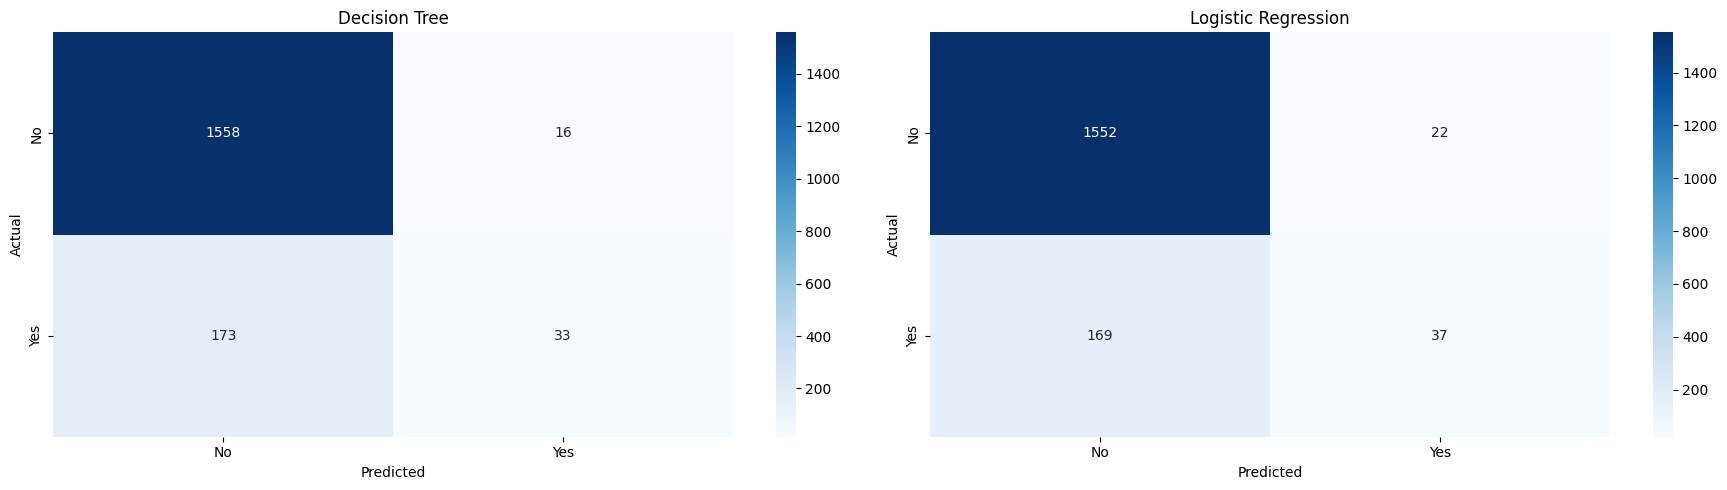

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for ax, cm_data, title in zip(axes, 
    [cm, cm_lr, ], 
    ['Decision Tree', 'Logistic Regression']):
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

The confusion matrix heatmaps compare all three models side by side. The Decision Tree shows a more balanced distribution between classes, while Logistic Regression and Random Forest heavily favor the majority class (No Investment).